rework of ch_9_2_first_nns.ipnynb to make cnns  
utilizing csv instead of loading as images   
balanced dataset  
6. 15x20 // CNN 1D LSTM // 3 - Live Data vs PerfectFam vs StreakMM  

# IMPORTS

In [16]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [17]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [22]:
df_alldata = pd.read_csv('../combined_dataset.csv')
# display(df_alldata)

In [23]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [27]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [33]:
orig_labels = list(df_w_live['labels'])

In [35]:
len(orig_labels)

132127

In [37]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [41]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [43]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [45]:
df_w_live['labels'] = replaced_labels

In [47]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [53]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [55]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [57]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [59]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [61]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [63]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [65]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


In [68]:
### Live Data
len(df_w_live[df_w_live['labels']==0])

42127

In [70]:
### PerfectMM & NearPerfectMM (PerfectFam)
len(df_w_live[df_w_live['labels']==1])

60000

In [72]:
### StreakMM
len(df_w_live[df_w_live['labels']==2])

30000

## Sample from Groups

### from Live Data

In [77]:
train_livedata = df_w_live[df_w_live['labels']==0].sample(n=20000, random_state=10)

In [79]:
train_livedata.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


### from PerfectFam

In [82]:
train_perfectfam = df_w_live[df_w_live['labels']==1].sample(n=20000, random_state=10)

In [84]:
train_perfectfam.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
4883,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,0,0,1,1,1,perfectmm_94_883
28477,0,0,0,0,0,0,1,1,1,0,...,0,1,1,1,0,0,1,1,1,perfectmm_712_477
8527,1,0,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,1,1,perfectmm_999_527


### from StreakMM

In [87]:
train_streakmm = df_w_live[df_w_live['labels']==2].sample(n=20000, random_state=10)

In [89]:
train_streakmm.head(3).head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
80412,1,1,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,2,streakmm_4_412
61296,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2,streakmm_229_296
63906,1,1,1,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,2,streakmm_14_906


### Get df_train (3 dfs into 1)

In [93]:
df_train = pd.concat([train_livedata, train_perfectfam, train_streakmm])

In [95]:
display(df_train.head(3))
print(len(df_train))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


60000


### Get df_test

In [99]:
### indices of df_train
train_idx = list(df_train.index)
len(train_idx)

60000

In [101]:
### indices of df_w_live
df_w_live_idx = list(df_w_live.index)
len(df_w_live_idx)

132127

In [103]:
### df_w_live_idx - train_idx
test_idx = list(set(df_w_live_idx)-set(train_idx))
len(test_idx)

72127

In [105]:
df_test = df_w_live.loc[test_idx]
display(df_test.head(3))
display(df_test.tail(3))
print(len(df_test))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131072,0,0,0,1,0,1,1,0,1,0,...,1,0,1,0,0,1,1,0,0,히읏차
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,1,perfectmm_456_3


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131065,1,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,신은없으니깐
131069,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,1,1,1,0,묘목있어요
131071,0,0,0,0,0,1,1,1,0,1,...,0,0,1,0,0,1,1,1,0,민쵸트코


72127


In [108]:
# df = df_w_live[df_w_live['labels']==2].sample(n=1, random_state=11)

In [110]:
# df

In [112]:
# ddf = df_w_live[df_w_live['labels']==2].sample(n=2, random_state=10)

In [114]:
# ddf

In [116]:
# dddf = pd.concat([df,ddf])

In [118]:
# dddf

In [120]:
# dddf.reset_index(drop=True)

In [122]:
# dddf = dddf.reset_index(drop=False)

In [124]:
# dddf 

In [126]:
# sorted(list(dddf.index))

In [128]:
# df_w_live[df_w_live['labels']==2].loc[[61296, 76131, 80412]]

In [130]:
# del dddf

# Create Pytorch Dataset (custom)

## Define Dataset Class

In [137]:
# Custom Dataset Class
## Needs AT LEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [141]:
# all_dataset = RecordsDataset(df_w_live)
train_alldataset = RecordsDataset(df_train)

In [143]:
test_alldataset = RecordsDataset(df_test)

## Split Train & Test

In [146]:
# train_size = int(0.7 * len(all_dataset))
# test_size = len(all_dataset) - train_size
# # train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(12))
# ### torch.Generator().manual_seed(42)

In [148]:
# train_alldataset
# len(train_alldataset)

In [150]:
# test_alldataset
# len(test_alldataset)

## Create Train & Test all_dataloaders

In [154]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [156]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [160]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

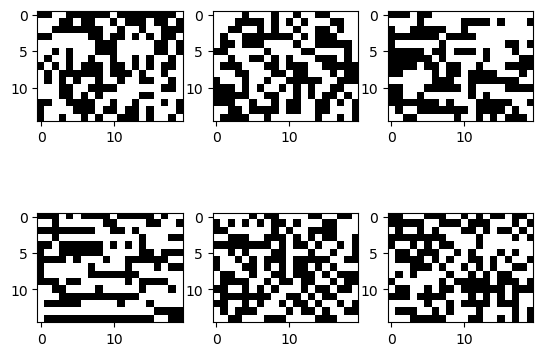

In [162]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [164]:
print(example_targets)

tensor([0, 1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 0, 2,
        0, 1, 0, 0, 1, 1, 0, 2])


### Check Test alldataloader

In [168]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

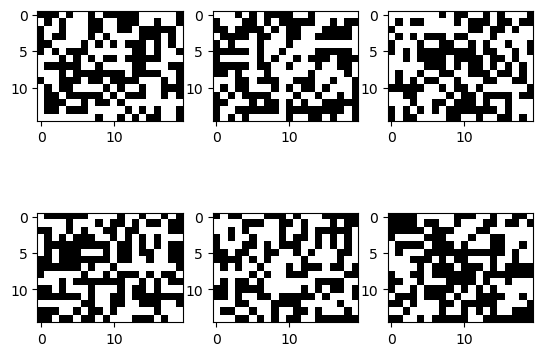

In [170]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [172]:
print(example_targets)

tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [1078]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
# num_epochs = 50
# num_epochs = 100
# num_epochs = 300
num_epochs = 500
# num_epochs = 1000

# learning_rate = 0.0001
learning_rate = 0.0003
# learning_rate = 0.001

In [1079]:
print(device)

mps


## Define Model

In [1081]:
### cnn_flat_v8.1_lstm_1drop_10epo.pth
### cnn_flat_v8.2_lstm_1drop_300epo.pth


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
        # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
        # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
        self.fc1 = nn.Linear(16*18, 128)
        # self.fc2 = nn.Linear(128, 64)
        
        self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64, num_layers=1)
        # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
        # self.lstm2 = nn.LSTM(input_size=64, batch_first=True, bidirectional=True, hidden_size=32)
        
        
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop1 = nn.Dropout(p=0.3)
        # self.drop2 = nn.Dropout(p=0.3)
        

    def forward(self, x):
        # print(f'{x.shape}')       # batch_size, 300
        
        x = x.reshape(-1, 1, 300)
        # print(x.shape)      # batch_size, 1, 300
        
        x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 256, 150
        # print(x.shap/e)
        x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 128, 75
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 37
        # print(x.shape)
        x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 18
        # print(x.shape)
        x = F.relu(self.conv5(x))   # -> batch_size, 16, 18
        # print(x.shape)

        x = torch.flatten(x, 1)     # -> batch_size, 288
        # print(f'flatten1: {x.shape}')
        x = self.drop1(x)
        
        # x, _ = self.lstm1(x)     # -> batch_size, 16
        # print(f'lstm1: {x.shape}')
        # # print(x)
        
        # x, _ = self.lstm2(x)     # -> batch_size, 16
        # print(f'lstm2: {x.shape}')
        
        
        x = F.relu(self.fc1(x), 1)     # -> batch_size, 128
        # x = self.drop1(x)
        # print(x.shape)
        
        x, _ = self.lstm1(x)     # -> batch_size, 64*2
        # print(f'lstm1: {x.shape}')
        
        # x, _ = self.lstm2(x)     # -> batch_size, 16
        # print(f'lstm2: {x.shape}')
        
        x = torch.flatten(x, 1)     # -> batch_size, 128
        # print(f'flatten2: {x.shape}')
        
        x = self.fc2(x)             # -> batch_size, num_classes(=3)
        # print(x.shape)
    
        
        return x
    
    
    
#######################    
# torch.Size([32, 300])
# torch.Size([32, 1, 300])
# torch.Size([32, 256, 300])
# torch.Size([32, 128, 150])
# torch.Size([32, 128, 75])
# torch.Size([32, 64, 75])
# torch.Size([32, 64, 37])
# torch.Size([32, 32, 37])
# torch.Size([32, 32, 18])
# torch.Size([32, 16, 18])
# flatten1: torch.Size([32, 288])
# torch.Size([32, 64])
# lstm1: torch.Size([32, 16])
# lstm2: torch.Size([32, 16])
# flatten2: torch.Size([32, 16])
# torch.Size([32, 3])


### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam)

### 10 epochs, initial loss: 0.608, final loss: 0.504 // 5 mins
### 50 epochs // initial loss: , final loss:  // 25 mins
### 100 epochs // initial loss: 0.586, final loss:  // 50 mins
### 300 epochs // initial loss: 0.569, final loss: 0.179 // 5176 secs


## Name Model

In [1083]:
PATH = f'../models/practice_4/balanced_cnn_1d_lstm_{str(num_epochs)}epo.pth'
# PATH = f'../models/practice_4/testing_balanced_cnn_1d_lstm_{str(num_epochs)}epo.pth'
# PATH = f'../models/practice_4/balanced_cnn_1d_lstm_lr001_{str(num_epochs)}epo.pth'
print(PATH)

../models/practice_4/balanced_cnn_1d_lstm_500epo.pth


## Train CNN

In [1085]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))








2024-05-24 01:12:04




  0%|          | 1/500 [00:10<1:28:08, 10.60s/it]

[1] loss: 0.518


  0%|          | 2/500 [00:21<1:28:08, 10.62s/it]

[2] loss: 0.462


  1%|          | 3/500 [00:32<1:28:39, 10.70s/it]

[3] loss: 0.459


  1%|          | 4/500 [00:42<1:29:04, 10.78s/it]

[4] loss: 0.455


  1%|          | 5/500 [00:53<1:28:42, 10.75s/it]

[5] loss: 0.451


  1%|          | 6/500 [01:04<1:28:59, 10.81s/it]

[6] loss: 0.448


  1%|▏         | 7/500 [01:15<1:28:35, 10.78s/it]

[7] loss: 0.445


  2%|▏         | 8/500 [01:25<1:28:07, 10.75s/it]

[8] loss: 0.443


  2%|▏         | 9/500 [01:36<1:27:51, 10.74s/it]

[9] loss: 0.441


  2%|▏         | 10/500 [01:47<1:28:00, 10.78s/it]

[10] loss: 0.441


  2%|▏         | 11/500 [01:58<1:27:30, 10.74s/it]

[11] loss: 0.439


  2%|▏         | 12/500 [02:09<1:27:33, 10.77s/it]

[12] loss: 0.438


  3%|▎         | 13/500 [02:19<1:27:31, 10.78s/it]

[13] loss: 0.437


  3%|▎         | 14/500 [02:30<1:27:15, 10.77s/it]

[14] loss: 0.436


  3%|▎         | 15/500 [02:41<1:27:17, 10.80s/it]

[15] loss: 0.434


  3%|▎         | 16/500 [02:52<1:26:57, 10.78s/it]

[16] loss: 0.432


  3%|▎         | 17/500 [03:02<1:26:37, 10.76s/it]

[17] loss: 0.430


  4%|▎         | 18/500 [03:13<1:26:33, 10.77s/it]

[18] loss: 0.428


  4%|▍         | 19/500 [03:24<1:26:34, 10.80s/it]

[19] loss: 0.426


  4%|▍         | 20/500 [03:35<1:26:08, 10.77s/it]

[20] loss: 0.424


  4%|▍         | 21/500 [03:46<1:26:04, 10.78s/it]

[21] loss: 0.421


  4%|▍         | 22/500 [03:56<1:26:00, 10.80s/it]

[22] loss: 0.419


  5%|▍         | 23/500 [04:07<1:26:12, 10.84s/it]

[23] loss: 0.415


  5%|▍         | 24/500 [04:18<1:25:55, 10.83s/it]

[24] loss: 0.412


  5%|▌         | 25/500 [04:29<1:25:37, 10.82s/it]

[25] loss: 0.408


  5%|▌         | 26/500 [04:40<1:25:39, 10.84s/it]

[26] loss: 0.404


  5%|▌         | 27/500 [04:51<1:27:10, 11.06s/it]

[27] loss: 0.400


  6%|▌         | 28/500 [05:02<1:26:25, 10.99s/it]

[28] loss: 0.395


  6%|▌         | 29/500 [05:13<1:25:47, 10.93s/it]

[29] loss: 0.390


  6%|▌         | 30/500 [05:24<1:25:10, 10.87s/it]

[30] loss: 0.385


  6%|▌         | 31/500 [05:35<1:24:53, 10.86s/it]

[31] loss: 0.380


  6%|▋         | 32/500 [05:46<1:25:27, 10.96s/it]

[32] loss: 0.376


  7%|▋         | 33/500 [05:56<1:24:37, 10.87s/it]

[33] loss: 0.369


  7%|▋         | 34/500 [06:07<1:24:09, 10.84s/it]

[34] loss: 0.366


  7%|▋         | 35/500 [06:18<1:23:51, 10.82s/it]

[35] loss: 0.358


  7%|▋         | 36/500 [06:30<1:25:30, 11.06s/it]

[36] loss: 0.354


  7%|▋         | 37/500 [06:42<1:27:36, 11.35s/it]

[37] loss: 0.350


  8%|▊         | 38/500 [06:53<1:28:08, 11.45s/it]

[38] loss: 0.345


  8%|▊         | 39/500 [07:04<1:27:08, 11.34s/it]

[39] loss: 0.338


  8%|▊         | 40/500 [07:16<1:26:25, 11.27s/it]

[40] loss: 0.333


  8%|▊         | 41/500 [07:26<1:25:07, 11.13s/it]

[41] loss: 0.328


  8%|▊         | 42/500 [07:38<1:26:14, 11.30s/it]

[42] loss: 0.323


  9%|▊         | 43/500 [07:49<1:25:01, 11.16s/it]

[43] loss: 0.321


  9%|▉         | 44/500 [08:00<1:24:26, 11.11s/it]

[44] loss: 0.316


  9%|▉         | 45/500 [08:11<1:23:52, 11.06s/it]

[45] loss: 0.309


  9%|▉         | 46/500 [08:21<1:22:53, 10.95s/it]

[46] loss: 0.306


  9%|▉         | 47/500 [08:32<1:22:00, 10.86s/it]

[47] loss: 0.299


 10%|▉         | 48/500 [08:43<1:21:54, 10.87s/it]

[48] loss: 0.296


 10%|▉         | 49/500 [08:54<1:21:17, 10.82s/it]

[49] loss: 0.292


 10%|█         | 50/500 [09:05<1:21:28, 10.86s/it]

[50] loss: 0.287


 10%|█         | 51/500 [09:17<1:24:04, 11.23s/it]

[51] loss: 0.282


 10%|█         | 52/500 [09:27<1:22:32, 11.06s/it]

[52] loss: 0.280


 11%|█         | 53/500 [09:38<1:21:49, 10.98s/it]

[53] loss: 0.275


 11%|█         | 54/500 [09:49<1:21:28, 10.96s/it]

[54] loss: 0.273


 11%|█         | 55/500 [10:00<1:20:58, 10.92s/it]

[55] loss: 0.269


 11%|█         | 56/500 [10:11<1:20:33, 10.89s/it]

[56] loss: 0.267


 11%|█▏        | 57/500 [10:21<1:19:54, 10.82s/it]

[57] loss: 0.263


 12%|█▏        | 58/500 [10:32<1:19:07, 10.74s/it]

[58] loss: 0.261


 12%|█▏        | 59/500 [10:43<1:19:53, 10.87s/it]

[59] loss: 0.256


 12%|█▏        | 60/500 [10:54<1:19:29, 10.84s/it]

[60] loss: 0.254


 12%|█▏        | 61/500 [11:05<1:19:14, 10.83s/it]

[61] loss: 0.251


 12%|█▏        | 62/500 [11:15<1:18:53, 10.81s/it]

[62] loss: 0.246


 13%|█▎        | 63/500 [11:26<1:18:27, 10.77s/it]

[63] loss: 0.240


 13%|█▎        | 64/500 [11:37<1:18:43, 10.83s/it]

[64] loss: 0.243


 13%|█▎        | 65/500 [11:48<1:18:27, 10.82s/it]

[65] loss: 0.240


 13%|█▎        | 66/500 [11:59<1:18:34, 10.86s/it]

[66] loss: 0.235


 13%|█▎        | 67/500 [12:10<1:18:21, 10.86s/it]

[67] loss: 0.233


 14%|█▎        | 68/500 [12:20<1:17:52, 10.82s/it]

[68] loss: 0.229


 14%|█▍        | 69/500 [12:31<1:17:30, 10.79s/it]

[69] loss: 0.228


 14%|█▍        | 70/500 [12:43<1:19:02, 11.03s/it]

[70] loss: 0.226


 14%|█▍        | 71/500 [12:55<1:21:35, 11.41s/it]

[71] loss: 0.222


 14%|█▍        | 72/500 [13:08<1:23:38, 11.73s/it]

[72] loss: 0.221


 15%|█▍        | 73/500 [13:20<1:26:00, 12.08s/it]

[73] loss: 0.224


 15%|█▍        | 74/500 [13:32<1:23:51, 11.81s/it]

[74] loss: 0.219


 15%|█▌        | 75/500 [13:42<1:21:35, 11.52s/it]

[75] loss: 0.217


 15%|█▌        | 76/500 [13:53<1:20:07, 11.34s/it]

[76] loss: 0.215


 15%|█▌        | 77/500 [14:04<1:18:59, 11.20s/it]

[77] loss: 0.210


 16%|█▌        | 78/500 [14:15<1:18:01, 11.09s/it]

[78] loss: 0.208


 16%|█▌        | 79/500 [14:26<1:17:17, 11.02s/it]

[79] loss: 0.208


 16%|█▌        | 80/500 [14:37<1:17:06, 11.01s/it]

[80] loss: 0.207


 16%|█▌        | 81/500 [14:48<1:16:31, 10.96s/it]

[81] loss: 0.205


 16%|█▋        | 82/500 [14:59<1:16:12, 10.94s/it]

[82] loss: 0.202


 17%|█▋        | 83/500 [15:10<1:16:06, 10.95s/it]

[83] loss: 0.200


 17%|█▋        | 84/500 [15:20<1:15:34, 10.90s/it]

[84] loss: 0.200


 17%|█▋        | 85/500 [15:31<1:14:50, 10.82s/it]

[85] loss: 0.194


 17%|█▋        | 86/500 [15:42<1:15:12, 10.90s/it]

[86] loss: 0.197


 17%|█▋        | 87/500 [15:53<1:14:52, 10.88s/it]

[87] loss: 0.196


 18%|█▊        | 88/500 [16:04<1:14:25, 10.84s/it]

[88] loss: 0.190


 18%|█▊        | 89/500 [16:15<1:14:03, 10.81s/it]

[89] loss: 0.192


 18%|█▊        | 90/500 [16:25<1:13:48, 10.80s/it]

[90] loss: 0.188


 18%|█▊        | 91/500 [16:36<1:14:06, 10.87s/it]

[91] loss: 0.188


 18%|█▊        | 92/500 [16:47<1:14:05, 10.90s/it]

[92] loss: 0.189


 19%|█▊        | 93/500 [16:58<1:13:43, 10.87s/it]

[93] loss: 0.183


 19%|█▉        | 94/500 [17:09<1:13:23, 10.85s/it]

[94] loss: 0.185


 19%|█▉        | 95/500 [17:20<1:13:11, 10.84s/it]

[95] loss: 0.184


 19%|█▉        | 96/500 [17:31<1:12:58, 10.84s/it]

[96] loss: 0.182


 19%|█▉        | 97/500 [17:42<1:13:07, 10.89s/it]

[97] loss: 0.180


 20%|█▉        | 98/500 [17:52<1:12:52, 10.88s/it]

[98] loss: 0.178


 20%|█▉        | 99/500 [18:04<1:13:25, 10.99s/it]

[99] loss: 0.174


 20%|██        | 100/500 [18:14<1:12:54, 10.94s/it]

[100] loss: 0.174


 20%|██        | 101/500 [18:25<1:12:12, 10.86s/it]

[101] loss: 0.173


 20%|██        | 102/500 [18:36<1:12:37, 10.95s/it]

[102] loss: 0.172


 21%|██        | 103/500 [18:47<1:12:16, 10.92s/it]

[103] loss: 0.173


 21%|██        | 104/500 [18:58<1:12:01, 10.91s/it]

[104] loss: 0.170


 21%|██        | 105/500 [19:09<1:11:48, 10.91s/it]

[105] loss: 0.168


 21%|██        | 106/500 [19:20<1:11:14, 10.85s/it]

[106] loss: 0.169


 21%|██▏       | 107/500 [19:30<1:10:52, 10.82s/it]

[107] loss: 0.165


 22%|██▏       | 108/500 [19:42<1:11:25, 10.93s/it]

[108] loss: 0.167


 22%|██▏       | 109/500 [19:52<1:10:54, 10.88s/it]

[109] loss: 0.167


 22%|██▏       | 110/500 [20:03<1:10:29, 10.84s/it]

[110] loss: 0.163


 22%|██▏       | 111/500 [20:14<1:10:25, 10.86s/it]

[111] loss: 0.163


 22%|██▏       | 112/500 [20:25<1:10:07, 10.84s/it]

[112] loss: 0.159


 23%|██▎       | 113/500 [20:36<1:10:13, 10.89s/it]

[113] loss: 0.161


 23%|██▎       | 114/500 [20:47<1:10:08, 10.90s/it]

[114] loss: 0.161


 23%|██▎       | 115/500 [20:58<1:09:49, 10.88s/it]

[115] loss: 0.160


 23%|██▎       | 116/500 [21:08<1:09:39, 10.88s/it]

[116] loss: 0.158


 23%|██▎       | 117/500 [21:19<1:09:24, 10.87s/it]

[117] loss: 0.158


 24%|██▎       | 118/500 [21:30<1:08:53, 10.82s/it]

[118] loss: 0.153


 24%|██▍       | 119/500 [21:41<1:09:09, 10.89s/it]

[119] loss: 0.153


 24%|██▍       | 120/500 [21:52<1:09:01, 10.90s/it]

[120] loss: 0.154


 24%|██▍       | 121/500 [22:03<1:08:49, 10.90s/it]

[121] loss: 0.153


 24%|██▍       | 122/500 [22:14<1:08:37, 10.89s/it]

[122] loss: 0.153


 25%|██▍       | 123/500 [22:25<1:08:12, 10.85s/it]

[123] loss: 0.149


 25%|██▍       | 124/500 [22:36<1:08:29, 10.93s/it]

[124] loss: 0.153


 25%|██▌       | 125/500 [22:46<1:08:10, 10.91s/it]

[125] loss: 0.149


 25%|██▌       | 126/500 [22:57<1:08:00, 10.91s/it]

[126] loss: 0.148


 25%|██▌       | 127/500 [23:08<1:07:51, 10.92s/it]

[127] loss: 0.149


 26%|██▌       | 128/500 [23:19<1:07:25, 10.87s/it]

[128] loss: 0.148


 26%|██▌       | 129/500 [23:30<1:06:59, 10.83s/it]

[129] loss: 0.145


 26%|██▌       | 130/500 [23:41<1:07:28, 10.94s/it]

[130] loss: 0.144


 26%|██▌       | 131/500 [23:52<1:06:45, 10.85s/it]

[131] loss: 0.146


 26%|██▋       | 132/500 [24:02<1:06:29, 10.84s/it]

[132] loss: 0.144


 27%|██▋       | 133/500 [24:13<1:06:31, 10.88s/it]

[133] loss: 0.141


 27%|██▋       | 134/500 [24:24<1:06:13, 10.86s/it]

[134] loss: 0.142


 27%|██▋       | 135/500 [24:35<1:06:19, 10.90s/it]

[135] loss: 0.145


 27%|██▋       | 136/500 [24:46<1:06:41, 10.99s/it]

[136] loss: 0.142


 27%|██▋       | 137/500 [24:57<1:06:13, 10.95s/it]

[137] loss: 0.140


 28%|██▊       | 138/500 [25:08<1:05:56, 10.93s/it]

[138] loss: 0.139


 28%|██▊       | 139/500 [25:20<1:06:46, 11.10s/it]

[139] loss: 0.142


 28%|██▊       | 140/500 [25:31<1:06:16, 11.05s/it]

[140] loss: 0.140


 28%|██▊       | 141/500 [25:41<1:05:33, 10.96s/it]

[141] loss: 0.136


 28%|██▊       | 142/500 [25:52<1:05:14, 10.93s/it]

[142] loss: 0.139


 29%|██▊       | 143/500 [26:03<1:04:56, 10.91s/it]

[143] loss: 0.136


 29%|██▉       | 144/500 [26:14<1:04:22, 10.85s/it]

[144] loss: 0.134


 29%|██▉       | 145/500 [26:25<1:04:09, 10.84s/it]

[145] loss: 0.135


 29%|██▉       | 146/500 [26:35<1:03:53, 10.83s/it]

[146] loss: 0.135


 29%|██▉       | 147/500 [26:46<1:03:36, 10.81s/it]

[147] loss: 0.136


 30%|██▉       | 148/500 [26:57<1:03:21, 10.80s/it]

[148] loss: 0.132


 30%|██▉       | 149/500 [27:08<1:03:07, 10.79s/it]

[149] loss: 0.131


 30%|███       | 150/500 [27:19<1:02:57, 10.79s/it]

[150] loss: 0.133


 30%|███       | 151/500 [27:30<1:03:09, 10.86s/it]

[151] loss: 0.131


 30%|███       | 152/500 [27:40<1:02:51, 10.84s/it]

[152] loss: 0.133


 31%|███       | 153/500 [27:51<1:02:35, 10.82s/it]

[153] loss: 0.131


 31%|███       | 154/500 [28:02<1:02:29, 10.84s/it]

[154] loss: 0.129


 31%|███       | 155/500 [28:13<1:02:18, 10.84s/it]

[155] loss: 0.129


 31%|███       | 156/500 [28:24<1:01:55, 10.80s/it]

[156] loss: 0.130


 31%|███▏      | 157/500 [28:34<1:01:41, 10.79s/it]

[157] loss: 0.130


 32%|███▏      | 158/500 [28:45<1:01:40, 10.82s/it]

[158] loss: 0.127


 32%|███▏      | 159/500 [28:56<1:01:26, 10.81s/it]

[159] loss: 0.129


 32%|███▏      | 160/500 [29:07<1:01:19, 10.82s/it]

[160] loss: 0.130


 32%|███▏      | 161/500 [29:18<1:01:05, 10.81s/it]

[161] loss: 0.126


 32%|███▏      | 162/500 [29:28<1:00:56, 10.82s/it]

[162] loss: 0.124


 33%|███▎      | 163/500 [29:39<1:00:57, 10.85s/it]

[163] loss: 0.125


 33%|███▎      | 164/500 [29:50<1:00:53, 10.87s/it]

[164] loss: 0.124


 33%|███▎      | 165/500 [30:01<1:00:31, 10.84s/it]

[165] loss: 0.124


 33%|███▎      | 166/500 [30:12<1:00:06, 10.80s/it]

[166] loss: 0.124


 33%|███▎      | 167/500 [30:23<1:00:02, 10.82s/it]

[167] loss: 0.125


 34%|███▎      | 168/500 [30:34<1:00:00, 10.84s/it]

[168] loss: 0.123


 34%|███▍      | 169/500 [30:44<59:35, 10.80s/it]  

[169] loss: 0.124


 34%|███▍      | 170/500 [30:55<59:23, 10.80s/it]

[170] loss: 0.122


 34%|███▍      | 171/500 [31:06<59:15, 10.81s/it]

[171] loss: 0.123


 34%|███▍      | 172/500 [31:17<59:08, 10.82s/it]

[172] loss: 0.121


 35%|███▍      | 173/500 [31:28<59:09, 10.85s/it]

[173] loss: 0.121


 35%|███▍      | 174/500 [31:38<58:48, 10.82s/it]

[174] loss: 0.121


 35%|███▌      | 175/500 [31:49<58:35, 10.82s/it]

[175] loss: 0.121


 35%|███▌      | 176/500 [32:00<58:54, 10.91s/it]

[176] loss: 0.122


 35%|███▌      | 177/500 [32:11<58:35, 10.88s/it]

[177] loss: 0.122


 36%|███▌      | 178/500 [32:22<58:07, 10.83s/it]

[178] loss: 0.121


 36%|███▌      | 179/500 [32:33<57:54, 10.82s/it]

[179] loss: 0.117


 36%|███▌      | 180/500 [32:44<57:48, 10.84s/it]

[180] loss: 0.118


 36%|███▌      | 181/500 [32:55<57:45, 10.86s/it]

[181] loss: 0.119


 36%|███▋      | 182/500 [33:05<57:29, 10.85s/it]

[182] loss: 0.117


 37%|███▋      | 183/500 [33:16<57:14, 10.83s/it]

[183] loss: 0.118


 37%|███▋      | 184/500 [33:27<57:17, 10.88s/it]

[184] loss: 0.115


 37%|███▋      | 185/500 [33:38<57:08, 10.89s/it]

[185] loss: 0.114


 37%|███▋      | 186/500 [33:49<57:20, 10.96s/it]

[186] loss: 0.119


 37%|███▋      | 187/500 [34:00<56:45, 10.88s/it]

[187] loss: 0.116


 38%|███▊      | 188/500 [34:11<56:26, 10.85s/it]

[188] loss: 0.114


 38%|███▊      | 189/500 [34:22<56:21, 10.87s/it]

[189] loss: 0.112


 38%|███▊      | 190/500 [34:32<56:08, 10.87s/it]

[190] loss: 0.114


 38%|███▊      | 191/500 [34:43<55:51, 10.85s/it]

[191] loss: 0.113


 38%|███▊      | 192/500 [34:54<55:42, 10.85s/it]

[192] loss: 0.113


 39%|███▊      | 193/500 [35:05<55:29, 10.84s/it]

[193] loss: 0.112


 39%|███▉      | 194/500 [35:16<55:12, 10.82s/it]

[194] loss: 0.112


 39%|███▉      | 195/500 [35:26<54:59, 10.82s/it]

[195] loss: 0.113


 39%|███▉      | 196/500 [35:37<54:48, 10.82s/it]

[196] loss: 0.112


 39%|███▉      | 197/500 [35:48<55:04, 10.91s/it]

[197] loss: 0.116


 40%|███▉      | 198/500 [35:59<55:10, 10.96s/it]

[198] loss: 0.108


 40%|███▉      | 199/500 [36:10<54:47, 10.92s/it]

[199] loss: 0.109


 40%|████      | 200/500 [36:21<54:16, 10.86s/it]

[200] loss: 0.112


 40%|████      | 201/500 [36:32<54:05, 10.85s/it]

[201] loss: 0.111


 40%|████      | 202/500 [36:43<54:16, 10.93s/it]

[202] loss: 0.110


 41%|████      | 203/500 [36:54<53:55, 10.89s/it]

[203] loss: 0.111


 41%|████      | 204/500 [37:05<53:45, 10.90s/it]

[204] loss: 0.108


 41%|████      | 205/500 [37:16<53:32, 10.89s/it]

[205] loss: 0.110


 41%|████      | 206/500 [37:26<53:15, 10.87s/it]

[206] loss: 0.109


 41%|████▏     | 207/500 [37:37<53:05, 10.87s/it]

[207] loss: 0.108


 42%|████▏     | 208/500 [37:48<52:56, 10.88s/it]

[208] loss: 0.111


 42%|████▏     | 209/500 [37:59<53:13, 10.97s/it]

[209] loss: 0.110


 42%|████▏     | 210/500 [38:10<53:12, 11.01s/it]

[210] loss: 0.109


 42%|████▏     | 211/500 [38:21<52:56, 10.99s/it]

[211] loss: 0.108


 42%|████▏     | 212/500 [38:32<52:12, 10.88s/it]

[212] loss: 0.107


 43%|████▎     | 213/500 [38:44<53:02, 11.09s/it]

[213] loss: 0.110


 43%|████▎     | 214/500 [38:55<52:41, 11.05s/it]

[214] loss: 0.107


 43%|████▎     | 215/500 [39:05<52:10, 10.99s/it]

[215] loss: 0.109


 43%|████▎     | 216/500 [39:16<51:37, 10.91s/it]

[216] loss: 0.107


 43%|████▎     | 217/500 [39:27<51:20, 10.89s/it]

[217] loss: 0.107


 44%|████▎     | 218/500 [39:38<50:56, 10.84s/it]

[218] loss: 0.104


 44%|████▍     | 219/500 [39:49<51:08, 10.92s/it]

[219] loss: 0.102


 44%|████▍     | 220/500 [40:00<50:51, 10.90s/it]

[220] loss: 0.105


 44%|████▍     | 221/500 [40:10<50:28, 10.86s/it]

[221] loss: 0.101


 44%|████▍     | 222/500 [40:21<50:08, 10.82s/it]

[222] loss: 0.105


 45%|████▍     | 223/500 [40:32<49:55, 10.81s/it]

[223] loss: 0.106


 45%|████▍     | 224/500 [40:43<49:45, 10.82s/it]

[224] loss: 0.104


 45%|████▌     | 225/500 [40:53<49:20, 10.77s/it]

[225] loss: 0.103


 45%|████▌     | 226/500 [41:04<49:11, 10.77s/it]

[226] loss: 0.108


 45%|████▌     | 227/500 [41:15<49:02, 10.78s/it]

[227] loss: 0.103


 46%|████▌     | 228/500 [41:26<49:06, 10.83s/it]

[228] loss: 0.103


 46%|████▌     | 229/500 [41:37<48:45, 10.80s/it]

[229] loss: 0.104


 46%|████▌     | 230/500 [41:47<48:36, 10.80s/it]

[230] loss: 0.103


 46%|████▌     | 231/500 [41:58<48:14, 10.76s/it]

[231] loss: 0.103


 46%|████▋     | 232/500 [42:09<48:05, 10.77s/it]

[232] loss: 0.103


 47%|████▋     | 233/500 [42:20<47:54, 10.76s/it]

[233] loss: 0.100


 47%|████▋     | 234/500 [42:30<47:41, 10.76s/it]

[234] loss: 0.102


 47%|████▋     | 235/500 [42:41<47:38, 10.79s/it]

[235] loss: 0.099


 47%|████▋     | 236/500 [42:52<47:32, 10.81s/it]

[236] loss: 0.101


 47%|████▋     | 237/500 [43:03<47:13, 10.78s/it]

[237] loss: 0.101


 48%|████▊     | 238/500 [43:14<46:58, 10.76s/it]

[238] loss: 0.101


 48%|████▊     | 239/500 [43:24<46:53, 10.78s/it]

[239] loss: 0.101


 48%|████▊     | 240/500 [43:35<46:36, 10.75s/it]

[240] loss: 0.099


 48%|████▊     | 241/500 [43:46<46:35, 10.79s/it]

[241] loss: 0.103


 48%|████▊     | 242/500 [43:57<46:32, 10.82s/it]

[242] loss: 0.100


 49%|████▊     | 243/500 [44:08<46:14, 10.80s/it]

[243] loss: 0.101


 49%|████▉     | 244/500 [44:18<46:08, 10.81s/it]

[244] loss: 0.099


 49%|████▉     | 245/500 [44:29<46:03, 10.84s/it]

[245] loss: 0.098


 49%|████▉     | 246/500 [44:40<45:42, 10.80s/it]

[246] loss: 0.103


 49%|████▉     | 247/500 [44:51<45:32, 10.80s/it]

[247] loss: 0.097


 50%|████▉     | 248/500 [45:02<45:24, 10.81s/it]

[248] loss: 0.097


 50%|████▉     | 249/500 [45:12<45:07, 10.79s/it]

[249] loss: 0.099


 50%|█████     | 250/500 [45:23<44:55, 10.78s/it]

[250] loss: 0.099


 50%|█████     | 251/500 [45:34<44:43, 10.78s/it]

[251] loss: 0.098


 50%|█████     | 252/500 [45:45<44:31, 10.77s/it]

[252] loss: 0.097


 51%|█████     | 253/500 [45:56<44:39, 10.85s/it]

[253] loss: 0.097


 51%|█████     | 254/500 [46:06<44:22, 10.82s/it]

[254] loss: 0.095


 51%|█████     | 255/500 [46:17<44:07, 10.81s/it]

[255] loss: 0.098


 51%|█████     | 256/500 [46:28<43:52, 10.79s/it]

[256] loss: 0.093


 51%|█████▏    | 257/500 [46:39<44:11, 10.91s/it]

[257] loss: 0.095


 52%|█████▏    | 258/500 [46:50<44:01, 10.91s/it]

[258] loss: 0.097


 52%|█████▏    | 259/500 [47:01<43:36, 10.86s/it]

[259] loss: 0.097


 52%|█████▏    | 260/500 [47:12<43:18, 10.83s/it]

[260] loss: 0.097


 52%|█████▏    | 261/500 [47:22<43:12, 10.85s/it]

[261] loss: 0.094


 52%|█████▏    | 262/500 [47:33<42:54, 10.82s/it]

[262] loss: 0.097


 53%|█████▎    | 263/500 [47:44<42:41, 10.81s/it]

[263] loss: 0.095


 53%|█████▎    | 264/500 [47:55<42:29, 10.80s/it]

[264] loss: 0.095


 53%|█████▎    | 265/500 [48:05<42:10, 10.77s/it]

[265] loss: 0.095


 53%|█████▎    | 266/500 [48:16<42:03, 10.78s/it]

[266] loss: 0.096


 53%|█████▎    | 267/500 [48:27<41:53, 10.79s/it]

[267] loss: 0.094


 54%|█████▎    | 268/500 [48:38<41:34, 10.75s/it]

[268] loss: 0.095


 54%|█████▍    | 269/500 [48:49<41:29, 10.78s/it]

[269] loss: 0.091


 54%|█████▍    | 270/500 [48:59<41:25, 10.80s/it]

[270] loss: 0.093


 54%|█████▍    | 271/500 [49:10<41:08, 10.78s/it]

[271] loss: 0.095


 54%|█████▍    | 272/500 [49:21<41:01, 10.80s/it]

[272] loss: 0.096


 55%|█████▍    | 273/500 [49:32<40:49, 10.79s/it]

[273] loss: 0.094


 55%|█████▍    | 274/500 [49:43<40:35, 10.78s/it]

[274] loss: 0.092


 55%|█████▌    | 275/500 [49:54<41:19, 11.02s/it]

[275] loss: 0.094


 55%|█████▌    | 276/500 [50:05<40:51, 10.95s/it]

[276] loss: 0.090


 55%|█████▌    | 277/500 [50:16<40:24, 10.87s/it]

[277] loss: 0.092


 56%|█████▌    | 278/500 [50:26<40:12, 10.87s/it]

[278] loss: 0.090


 56%|█████▌    | 279/500 [50:37<40:00, 10.86s/it]

[279] loss: 0.093


 56%|█████▌    | 280/500 [50:48<39:43, 10.83s/it]

[280] loss: 0.091


 56%|█████▌    | 281/500 [50:59<39:32, 10.83s/it]

[281] loss: 0.095


 56%|█████▋    | 282/500 [51:10<39:18, 10.82s/it]

[282] loss: 0.092


 57%|█████▋    | 283/500 [51:21<39:12, 10.84s/it]

[283] loss: 0.093


 57%|█████▋    | 284/500 [51:31<38:56, 10.82s/it]

[284] loss: 0.093


 57%|█████▋    | 285/500 [51:42<38:46, 10.82s/it]

[285] loss: 0.090


 57%|█████▋    | 286/500 [51:53<38:36, 10.83s/it]

[286] loss: 0.089


 57%|█████▋    | 287/500 [52:04<38:23, 10.82s/it]

[287] loss: 0.091


 58%|█████▊    | 288/500 [52:15<38:17, 10.84s/it]

[288] loss: 0.091


 58%|█████▊    | 289/500 [52:26<38:05, 10.83s/it]

[289] loss: 0.092


 58%|█████▊    | 290/500 [52:36<38:03, 10.88s/it]

[290] loss: 0.089


 58%|█████▊    | 291/500 [52:47<37:56, 10.89s/it]

[291] loss: 0.091


 58%|█████▊    | 292/500 [52:58<37:48, 10.90s/it]

[292] loss: 0.092


 59%|█████▊    | 293/500 [53:09<37:24, 10.84s/it]

[293] loss: 0.089


 59%|█████▉    | 294/500 [53:20<37:19, 10.87s/it]

[294] loss: 0.088


 59%|█████▉    | 295/500 [53:31<37:05, 10.86s/it]

[295] loss: 0.087


 59%|█████▉    | 296/500 [53:42<36:52, 10.84s/it]

[296] loss: 0.090


 59%|█████▉    | 297/500 [53:52<36:38, 10.83s/it]

[297] loss: 0.089


 60%|█████▉    | 298/500 [54:03<36:27, 10.83s/it]

[298] loss: 0.086


 60%|█████▉    | 299/500 [54:14<36:11, 10.80s/it]

[299] loss: 0.091


 60%|██████    | 300/500 [54:25<36:04, 10.82s/it]

[300] loss: 0.087


 60%|██████    | 301/500 [54:36<35:52, 10.82s/it]

[301] loss: 0.091


 60%|██████    | 302/500 [54:46<35:36, 10.79s/it]

[302] loss: 0.089


 61%|██████    | 303/500 [54:57<35:26, 10.79s/it]

[303] loss: 0.089


 61%|██████    | 304/500 [55:08<35:24, 10.84s/it]

[304] loss: 0.090


 61%|██████    | 305/500 [55:19<35:11, 10.83s/it]

[305] loss: 0.086


 61%|██████    | 306/500 [55:30<34:57, 10.81s/it]

[306] loss: 0.088


 61%|██████▏   | 307/500 [55:41<34:45, 10.81s/it]

[307] loss: 0.090


 62%|██████▏   | 308/500 [55:51<34:32, 10.80s/it]

[308] loss: 0.088


 62%|██████▏   | 309/500 [56:02<34:30, 10.84s/it]

[309] loss: 0.089


 62%|██████▏   | 310/500 [56:13<34:18, 10.83s/it]

[310] loss: 0.086


 62%|██████▏   | 311/500 [56:24<34:02, 10.81s/it]

[311] loss: 0.088


 62%|██████▏   | 312/500 [56:35<33:58, 10.84s/it]

[312] loss: 0.091


 63%|██████▎   | 313/500 [56:46<33:50, 10.86s/it]

[313] loss: 0.090


 63%|██████▎   | 314/500 [56:56<33:31, 10.82s/it]

[314] loss: 0.090


 63%|██████▎   | 315/500 [57:07<33:15, 10.79s/it]

[315] loss: 0.087


 63%|██████▎   | 316/500 [57:18<33:03, 10.78s/it]

[316] loss: 0.087


 63%|██████▎   | 317/500 [57:29<33:02, 10.83s/it]

[317] loss: 0.087


 64%|██████▎   | 318/500 [57:40<32:55, 10.86s/it]

[318] loss: 0.088


 64%|██████▍   | 319/500 [57:51<32:48, 10.88s/it]

[319] loss: 0.088


 64%|██████▍   | 320/500 [58:01<32:36, 10.87s/it]

[320] loss: 0.087


 64%|██████▍   | 321/500 [58:12<32:20, 10.84s/it]

[321] loss: 0.086


 64%|██████▍   | 322/500 [58:23<32:11, 10.85s/it]

[322] loss: 0.087


 65%|██████▍   | 323/500 [58:34<31:56, 10.83s/it]

[323] loss: 0.088


 65%|██████▍   | 324/500 [58:45<31:42, 10.81s/it]

[324] loss: 0.086


 65%|██████▌   | 325/500 [58:56<31:35, 10.83s/it]

[325] loss: 0.087


 65%|██████▌   | 326/500 [59:06<31:21, 10.81s/it]

[326] loss: 0.088


 65%|██████▌   | 327/500 [59:17<31:02, 10.77s/it]

[327] loss: 0.086


 66%|██████▌   | 328/500 [59:28<30:54, 10.78s/it]

[328] loss: 0.088


 66%|██████▌   | 329/500 [59:39<30:41, 10.77s/it]

[329] loss: 0.084


 66%|██████▌   | 330/500 [59:49<30:34, 10.79s/it]

[330] loss: 0.087


 66%|██████▌   | 331/500 [1:00:01<30:43, 10.91s/it]

[331] loss: 0.085


 66%|██████▋   | 332/500 [1:00:11<30:25, 10.87s/it]

[332] loss: 0.086


 67%|██████▋   | 333/500 [1:00:22<30:07, 10.82s/it]

[333] loss: 0.085


 67%|██████▋   | 334/500 [1:00:33<29:58, 10.83s/it]

[334] loss: 0.084


 67%|██████▋   | 335/500 [1:00:44<29:50, 10.85s/it]

[335] loss: 0.084


 67%|██████▋   | 336/500 [1:00:54<29:31, 10.80s/it]

[336] loss: 0.082


 67%|██████▋   | 337/500 [1:01:05<29:18, 10.79s/it]

[337] loss: 0.087


 68%|██████▊   | 338/500 [1:01:16<29:25, 10.90s/it]

[338] loss: 0.087


 68%|██████▊   | 339/500 [1:01:27<29:11, 10.88s/it]

[339] loss: 0.083


 68%|██████▊   | 340/500 [1:01:38<28:50, 10.81s/it]

[340] loss: 0.083


 68%|██████▊   | 341/500 [1:01:49<28:43, 10.84s/it]

[341] loss: 0.086


 68%|██████▊   | 342/500 [1:02:00<28:28, 10.81s/it]

[342] loss: 0.084


 69%|██████▊   | 343/500 [1:02:10<28:21, 10.84s/it]

[343] loss: 0.085


 69%|██████▉   | 344/500 [1:02:21<28:08, 10.82s/it]

[344] loss: 0.086


 69%|██████▉   | 345/500 [1:02:32<27:51, 10.79s/it]

[345] loss: 0.085


 69%|██████▉   | 346/500 [1:02:43<27:41, 10.79s/it]

[346] loss: 0.086


 69%|██████▉   | 347/500 [1:02:54<27:31, 10.79s/it]

[347] loss: 0.082


 70%|██████▉   | 348/500 [1:03:04<27:13, 10.75s/it]

[348] loss: 0.084


 70%|██████▉   | 349/500 [1:03:15<27:10, 10.80s/it]

[349] loss: 0.087


 70%|███████   | 350/500 [1:03:26<27:06, 10.84s/it]

[350] loss: 0.085


 70%|███████   | 351/500 [1:03:37<26:54, 10.83s/it]

[351] loss: 0.083


 70%|███████   | 352/500 [1:03:48<26:46, 10.85s/it]

[352] loss: 0.086


 71%|███████   | 353/500 [1:03:59<26:54, 10.99s/it]

[353] loss: 0.082


 71%|███████   | 354/500 [1:04:10<26:37, 10.94s/it]

[354] loss: 0.084


 71%|███████   | 355/500 [1:04:21<26:17, 10.88s/it]

[355] loss: 0.086


 71%|███████   | 356/500 [1:04:31<26:03, 10.86s/it]

[356] loss: 0.085


 71%|███████▏  | 357/500 [1:04:42<25:47, 10.82s/it]

[357] loss: 0.079


 72%|███████▏  | 358/500 [1:04:53<25:32, 10.79s/it]

[358] loss: 0.084


 72%|███████▏  | 359/500 [1:05:04<25:23, 10.81s/it]

[359] loss: 0.082


 72%|███████▏  | 360/500 [1:05:15<25:13, 10.81s/it]

[360] loss: 0.085


 72%|███████▏  | 361/500 [1:05:25<25:00, 10.80s/it]

[361] loss: 0.082


 72%|███████▏  | 362/500 [1:05:36<24:46, 10.77s/it]

[362] loss: 0.082


 73%|███████▎  | 363/500 [1:05:47<24:39, 10.80s/it]

[363] loss: 0.083


 73%|███████▎  | 364/500 [1:05:58<24:27, 10.79s/it]

[364] loss: 0.082


 73%|███████▎  | 365/500 [1:06:08<24:15, 10.78s/it]

[365] loss: 0.085


 73%|███████▎  | 366/500 [1:06:19<24:04, 10.78s/it]

[366] loss: 0.080


 73%|███████▎  | 367/500 [1:06:30<23:48, 10.74s/it]

[367] loss: 0.081


 74%|███████▎  | 368/500 [1:06:41<23:44, 10.79s/it]

[368] loss: 0.080


 74%|███████▍  | 369/500 [1:06:52<23:33, 10.79s/it]

[369] loss: 0.081


 74%|███████▍  | 370/500 [1:07:02<23:17, 10.75s/it]

[370] loss: 0.084


 74%|███████▍  | 371/500 [1:07:13<23:07, 10.76s/it]

[371] loss: 0.083


 74%|███████▍  | 372/500 [1:07:24<23:01, 10.79s/it]

[372] loss: 0.081


 75%|███████▍  | 373/500 [1:07:35<22:58, 10.85s/it]

[373] loss: 0.081


 75%|███████▍  | 374/500 [1:07:46<22:52, 10.89s/it]

[374] loss: 0.082


 75%|███████▌  | 375/500 [1:07:57<22:37, 10.86s/it]

[375] loss: 0.082


 75%|███████▌  | 376/500 [1:08:08<22:48, 11.04s/it]

[376] loss: 0.080


 75%|███████▌  | 377/500 [1:08:19<22:31, 10.99s/it]

[377] loss: 0.081


 76%|███████▌  | 378/500 [1:08:30<22:10, 10.90s/it]

[378] loss: 0.078


 76%|███████▌  | 379/500 [1:08:40<21:55, 10.87s/it]

[379] loss: 0.080


 76%|███████▌  | 380/500 [1:08:51<21:37, 10.81s/it]

[380] loss: 0.081


 76%|███████▌  | 381/500 [1:09:02<21:24, 10.80s/it]

[381] loss: 0.082


 76%|███████▋  | 382/500 [1:09:13<21:12, 10.78s/it]

[382] loss: 0.082


 77%|███████▋  | 383/500 [1:09:23<20:57, 10.75s/it]

[383] loss: 0.082


 77%|███████▋  | 384/500 [1:09:34<20:47, 10.75s/it]

[384] loss: 0.080


 77%|███████▋  | 385/500 [1:09:45<20:40, 10.79s/it]

[385] loss: 0.082


 77%|███████▋  | 386/500 [1:09:56<20:31, 10.80s/it]

[386] loss: 0.079


 77%|███████▋  | 387/500 [1:10:07<20:18, 10.79s/it]

[387] loss: 0.077


 78%|███████▊  | 388/500 [1:10:19<21:12, 11.36s/it]

[388] loss: 0.080


 78%|███████▊  | 389/500 [1:10:32<22:03, 11.92s/it]

[389] loss: 0.083


 78%|███████▊  | 390/500 [1:10:44<21:36, 11.78s/it]

[390] loss: 0.080


 78%|███████▊  | 391/500 [1:10:55<20:55, 11.52s/it]

[391] loss: 0.078


 78%|███████▊  | 392/500 [1:11:06<20:21, 11.31s/it]

[392] loss: 0.082


 79%|███████▊  | 393/500 [1:11:17<19:58, 11.20s/it]

[393] loss: 0.083


 79%|███████▉  | 394/500 [1:11:28<19:46, 11.19s/it]

[394] loss: 0.083


 79%|███████▉  | 395/500 [1:11:39<19:21, 11.07s/it]

[395] loss: 0.080


 79%|███████▉  | 396/500 [1:11:49<19:04, 11.00s/it]

[396] loss: 0.079


 79%|███████▉  | 397/500 [1:12:01<19:01, 11.09s/it]

[397] loss: 0.079


 80%|███████▉  | 398/500 [1:12:12<18:58, 11.16s/it]

[398] loss: 0.079


 80%|███████▉  | 399/500 [1:12:23<18:40, 11.10s/it]

[399] loss: 0.082


 80%|████████  | 400/500 [1:12:34<18:20, 11.01s/it]

[400] loss: 0.078


 80%|████████  | 401/500 [1:12:45<18:11, 11.03s/it]

[401] loss: 0.078


 80%|████████  | 402/500 [1:12:56<18:00, 11.03s/it]

[402] loss: 0.081


 81%|████████  | 403/500 [1:13:07<17:50, 11.04s/it]

[403] loss: 0.079


 81%|████████  | 404/500 [1:13:18<17:44, 11.09s/it]

[404] loss: 0.078


 81%|████████  | 405/500 [1:13:29<17:33, 11.09s/it]

[405] loss: 0.078


 81%|████████  | 406/500 [1:13:40<17:20, 11.07s/it]

[406] loss: 0.081


 81%|████████▏ | 407/500 [1:13:51<17:08, 11.06s/it]

[407] loss: 0.079


 82%|████████▏ | 408/500 [1:14:02<16:55, 11.04s/it]

[408] loss: 0.079


 82%|████████▏ | 409/500 [1:14:13<16:40, 11.00s/it]

[409] loss: 0.080


 82%|████████▏ | 410/500 [1:14:24<16:33, 11.04s/it]

[410] loss: 0.079


 82%|████████▏ | 411/500 [1:14:35<16:17, 10.99s/it]

[411] loss: 0.081


 82%|████████▏ | 412/500 [1:14:46<16:09, 11.02s/it]

[412] loss: 0.080


 83%|████████▎ | 413/500 [1:14:57<15:59, 11.03s/it]

[413] loss: 0.078


 83%|████████▎ | 414/500 [1:15:08<15:47, 11.01s/it]

[414] loss: 0.077


 83%|████████▎ | 415/500 [1:15:19<15:40, 11.06s/it]

[415] loss: 0.082


 83%|████████▎ | 416/500 [1:15:30<15:24, 11.00s/it]

[416] loss: 0.079


 83%|████████▎ | 417/500 [1:15:42<15:30, 11.21s/it]

[417] loss: 0.077


 84%|████████▎ | 418/500 [1:15:53<15:16, 11.18s/it]

[418] loss: 0.078


 84%|████████▍ | 419/500 [1:16:04<14:57, 11.08s/it]

[419] loss: 0.079


 84%|████████▍ | 420/500 [1:16:15<14:44, 11.06s/it]

[420] loss: 0.079


 84%|████████▍ | 421/500 [1:16:26<14:33, 11.06s/it]

[421] loss: 0.079


 84%|████████▍ | 422/500 [1:16:37<14:17, 11.00s/it]

[422] loss: 0.077


 85%|████████▍ | 423/500 [1:16:48<14:10, 11.05s/it]

[423] loss: 0.078


 85%|████████▍ | 424/500 [1:16:59<14:00, 11.06s/it]

[424] loss: 0.078


 85%|████████▌ | 425/500 [1:17:10<13:41, 10.95s/it]

[425] loss: 0.076


 85%|████████▌ | 426/500 [1:17:21<13:35, 11.01s/it]

[426] loss: 0.077


 85%|████████▌ | 427/500 [1:17:32<13:25, 11.04s/it]

[427] loss: 0.077


 86%|████████▌ | 428/500 [1:17:43<13:13, 11.03s/it]

[428] loss: 0.077


 86%|████████▌ | 429/500 [1:17:54<13:04, 11.05s/it]

[429] loss: 0.079


 86%|████████▌ | 430/500 [1:18:05<12:55, 11.08s/it]

[430] loss: 0.076


 86%|████████▌ | 431/500 [1:18:16<12:44, 11.08s/it]

[431] loss: 0.078


 86%|████████▋ | 432/500 [1:18:27<12:31, 11.05s/it]

[432] loss: 0.078


 87%|████████▋ | 433/500 [1:18:38<12:18, 11.02s/it]

[433] loss: 0.077


 87%|████████▋ | 434/500 [1:18:50<12:10, 11.07s/it]

[434] loss: 0.077


 87%|████████▋ | 435/500 [1:19:01<12:01, 11.09s/it]

[435] loss: 0.077


 87%|████████▋ | 436/500 [1:19:12<11:49, 11.09s/it]

[436] loss: 0.077


 87%|████████▋ | 437/500 [1:19:23<11:39, 11.10s/it]

[437] loss: 0.074


 88%|████████▊ | 438/500 [1:19:34<11:22, 11.00s/it]

[438] loss: 0.076


 88%|████████▊ | 439/500 [1:19:45<11:10, 11.00s/it]

[439] loss: 0.074


 88%|████████▊ | 440/500 [1:19:56<11:02, 11.04s/it]

[440] loss: 0.076


 88%|████████▊ | 441/500 [1:20:07<10:51, 11.04s/it]

[441] loss: 0.075


 88%|████████▊ | 442/500 [1:20:18<10:38, 11.01s/it]

[442] loss: 0.079


 89%|████████▊ | 443/500 [1:20:29<10:27, 11.00s/it]

[443] loss: 0.077


 89%|████████▉ | 444/500 [1:20:40<10:16, 11.01s/it]

[444] loss: 0.078


 89%|████████▉ | 445/500 [1:20:51<10:05, 11.01s/it]

[445] loss: 0.076


 89%|████████▉ | 446/500 [1:21:02<09:56, 11.04s/it]

[446] loss: 0.077


 89%|████████▉ | 447/500 [1:21:13<09:46, 11.06s/it]

[447] loss: 0.077


 90%|████████▉ | 448/500 [1:21:24<09:37, 11.11s/it]

[448] loss: 0.076


 90%|████████▉ | 449/500 [1:21:36<09:33, 11.24s/it]

[449] loss: 0.078


 90%|█████████ | 450/500 [1:21:47<09:27, 11.34s/it]

[450] loss: 0.075


 90%|█████████ | 451/500 [1:21:58<09:10, 11.23s/it]

[451] loss: 0.078


 90%|█████████ | 452/500 [1:22:09<08:56, 11.17s/it]

[452] loss: 0.075


 91%|█████████ | 453/500 [1:22:21<08:46, 11.20s/it]

[453] loss: 0.078


 91%|█████████ | 454/500 [1:22:32<08:31, 11.13s/it]

[454] loss: 0.076


 91%|█████████ | 455/500 [1:22:43<08:20, 11.12s/it]

[455] loss: 0.074


 91%|█████████ | 456/500 [1:22:54<08:08, 11.10s/it]

[456] loss: 0.077


 91%|█████████▏| 457/500 [1:23:05<07:55, 11.05s/it]

[457] loss: 0.080


 92%|█████████▏| 458/500 [1:23:16<07:43, 11.04s/it]

[458] loss: 0.074


 92%|█████████▏| 459/500 [1:23:27<07:31, 11.01s/it]

[459] loss: 0.075


 92%|█████████▏| 460/500 [1:23:37<07:18, 10.97s/it]

[460] loss: 0.077


 92%|█████████▏| 461/500 [1:23:48<07:06, 10.93s/it]

[461] loss: 0.077


 92%|█████████▏| 462/500 [1:23:59<06:54, 10.92s/it]

[462] loss: 0.077


 93%|█████████▎| 463/500 [1:24:10<06:43, 10.90s/it]

[463] loss: 0.076


 93%|█████████▎| 464/500 [1:24:21<06:30, 10.85s/it]

[464] loss: 0.077


 93%|█████████▎| 465/500 [1:24:32<06:18, 10.83s/it]

[465] loss: 0.077


 93%|█████████▎| 466/500 [1:24:42<06:08, 10.84s/it]

[466] loss: 0.073


 93%|█████████▎| 467/500 [1:24:54<06:01, 10.94s/it]

[467] loss: 0.076


 94%|█████████▎| 468/500 [1:25:05<05:51, 10.98s/it]

[468] loss: 0.076


 94%|█████████▍| 469/500 [1:25:16<05:42, 11.04s/it]

[469] loss: 0.076


 94%|█████████▍| 470/500 [1:25:27<05:34, 11.17s/it]

[470] loss: 0.075


 94%|█████████▍| 471/500 [1:25:38<05:22, 11.11s/it]

[471] loss: 0.078


 94%|█████████▍| 472/500 [1:25:49<05:10, 11.09s/it]

[472] loss: 0.072


 95%|█████████▍| 473/500 [1:26:01<05:00, 11.11s/it]

[473] loss: 0.080


 95%|█████████▍| 474/500 [1:26:12<04:48, 11.09s/it]

[474] loss: 0.076


 95%|█████████▌| 475/500 [1:26:23<04:36, 11.06s/it]

[475] loss: 0.075


 95%|█████████▌| 476/500 [1:26:33<04:23, 11.00s/it]

[476] loss: 0.076


 95%|█████████▌| 477/500 [1:26:44<04:11, 10.93s/it]

[477] loss: 0.074


 96%|█████████▌| 478/500 [1:26:55<04:01, 10.97s/it]

[478] loss: 0.075


 96%|█████████▌| 479/500 [1:27:06<03:51, 11.04s/it]

[479] loss: 0.075


 96%|█████████▌| 480/500 [1:27:17<03:39, 10.99s/it]

[480] loss: 0.074


 96%|█████████▌| 481/500 [1:27:28<03:29, 11.02s/it]

[481] loss: 0.076


 96%|█████████▋| 482/500 [1:27:39<03:18, 11.02s/it]

[482] loss: 0.074


 97%|█████████▋| 483/500 [1:27:50<03:07, 11.02s/it]

[483] loss: 0.075


 97%|█████████▋| 484/500 [1:28:01<02:56, 11.00s/it]

[484] loss: 0.074


 97%|█████████▋| 485/500 [1:28:13<02:46, 11.10s/it]

[485] loss: 0.076


 97%|█████████▋| 486/500 [1:28:24<02:35, 11.14s/it]

[486] loss: 0.080


 97%|█████████▋| 487/500 [1:28:35<02:24, 11.14s/it]

[487] loss: 0.074


 98%|█████████▊| 488/500 [1:28:46<02:13, 11.10s/it]

[488] loss: 0.075


 98%|█████████▊| 489/500 [1:28:57<02:01, 11.06s/it]

[489] loss: 0.074


 98%|█████████▊| 490/500 [1:29:08<01:50, 11.02s/it]

[490] loss: 0.075


 98%|█████████▊| 491/500 [1:29:19<01:39, 11.10s/it]

[491] loss: 0.073


 98%|█████████▊| 492/500 [1:29:31<01:29, 11.13s/it]

[492] loss: 0.073


 99%|█████████▊| 493/500 [1:29:41<01:17, 11.02s/it]

[493] loss: 0.075


 99%|█████████▉| 494/500 [1:29:52<01:05, 10.97s/it]

[494] loss: 0.076


 99%|█████████▉| 495/500 [1:30:03<00:54, 10.93s/it]

[495] loss: 0.076


 99%|█████████▉| 496/500 [1:30:14<00:43, 10.89s/it]

[496] loss: 0.073


 99%|█████████▉| 497/500 [1:30:25<00:32, 10.92s/it]

[497] loss: 0.075


100%|█████████▉| 498/500 [1:30:36<00:22, 11.04s/it]

[498] loss: 0.072


100%|█████████▉| 499/500 [1:30:47<00:11, 11.06s/it]

[499] loss: 0.074


100%|██████████| 500/500 [1:30:58<00:00, 10.92s/it]

[500] loss: 0.074
Finished Training

----------------------------------------------------
done in 5458.573s.
2024-05-24 02:43:02


In [1086]:
# labels

In [1087]:
# model(images)

## Save Model

In [1089]:
torch.save(model.state_dict(), PATH)

## Load Model

In [1091]:
# PATH = f'../models/practice_4/balanced_cnn_1d_lstm_10epo.pth'
print(PATH)

../models/practice_4/balanced_cnn_1d_lstm_500epo.pth


In [1092]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

ConvNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  (conv5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (lstm1): LSTM(128, 64, batch_first=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
)

## Test Model

In [1094]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



2024-05-24 02:43:03


Accuracy of the loaded model: 61.16849446115879 %

----------------------------------------------------
done in 12.912s.
2024-05-24 02:43:15


In [1095]:
predicted2

tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1], device='mps:0')

In [1096]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


72127
<class 'list'>


In [1097]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))

for i in range(num_classes):
    for j in range(num_classes):
        if (i, j) not in all_answers_dict.keys():
            # print((i,j))
            all_answers_dict[(i,j)] = 0

            

In [1098]:
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

In [1099]:
for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')

(0, 0) : 12916
(0, 1) : 9157
(0, 2) : 54
(1, 0) : 18775
(1, 1) : 21204
(1, 2) : 21
(2, 0) : 1
(2, 1) : 0
(2, 2) : 9999


In [1100]:
# (0, 0) : 19980
# (0, 1) : 2126
# (0, 2) : 21
# (1, 0) : 31576
# (1, 1) : 8422
# (1, 2) : 2
# (2, 0) : 2
# (2, 2) : 9998

In [1101]:
all_answers_dict.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])

In [1102]:
truth_0_tot = all_answers_dict[(0, 0)] + all_answers_dict[(0, 1)] + all_answers_dict[(0, 2)]
truth_0_tot

22127

In [1103]:
truth_1_tot = all_answers_dict[(1, 0)] + all_answers_dict[(1, 1)] + all_answers_dict[(1, 2)]
truth_1_tot

40000

In [1104]:
acc_0 = all_answers_dict[(0, 0)] / truth_0_tot
acc_0

0.5837212455371266

In [1105]:
acc_1 = all_answers_dict[(1, 1)] / truth_1_tot
acc_1

0.5301

In [1106]:
acc0_x_acc1 = acc_0 * acc_1
acc0_x_acc1

0.3094306322592308